## Reproduction of the UniformatBridge

- This is an **_unofficial_** reproduction of the experiment described in "Transformer language model for mapping construction schedule activities to uniformat categories" by Yoonhwa Jung, Julia Hockenmaier, and Mani Golparvar-Fard, 2024.
- The study can be accessed at https://doi.org/10.1016/j.autcon.2023.105183.

**Table of contents**    
- Reproduction of the UniformatBridge model implementation    
    - Data    
      - BIM and ASTM Uniformat categories    
      - ★ Additional Experiment: What if we simply duplicate scarce data for data balancing?    
      - Label Encoding    
      - Text Encoding    
      - Make DataLoader    
      - ★ Additional Datasets: ASTM Uniformat II Classification for Building Elements Description    
      - ★ Additional Datasets: Data Augmentation with GPT-2    
      - ★ Additional Datasets: Data Augmentation with GPT-4    
    - Fine-tuning (Train & Validation)    
    - Test    
    - Experimental Results    
      - Overall Results    
      - Class-wise Results    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=false
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
import time; start_time = time.time()

In [2]:
!python -V

Python 3.11.6


In [3]:
# Experimental Settings from Jung et al. (2024)
# 6p: "Five epochs with a batch size of 32, a dropout rate of 0.1, and a learning rate of 1.5e−5 were used to fine-tune the model."
epoch_size = 20 #5
batch_size = 32
dropout_rate = 0.1  # BertForSequenceClassification default dropout_rate = 0.1
learning_rate = 1.5e-5

# 7p: "In Table 2 and 3, 𝜇 is the average performance on three random seeds, and 𝜎 is their standard deviation."
rseed = 44

In [4]:
experiment_setting = {
    'rseed': rseed, 
    'epoch_size': epoch_size,
    'balancing': '' # '', 'simple_balancing', 'gpt2_balancing', 'gpt4_balancing'
}

# for writing output file names.
experiment_name = f'rseed{rseed}_epoch{epoch_size}_{experiment_setting["balancing"]}'

In [5]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Data

#### BIM and ASTM Uniformat categories

In [6]:
import pandas as pd
dataset_path = "E:/_datasets/jung_et_al_2024/"  # Data should not be shared publicly.
df = pd.read_excel(dataset_path+"0-overall-level3.xlsx", header=0)

cls = 'Level3'
df = df.loc[:, ['predwbs2', 'predwbs', 'predtask', 'wbs2', 'wbs', 'name', 'sucwbs2', 'sucwbs', 'suctask', cls]]

In [7]:
new_tokens = ['[pred]', '[succ]']

df['text'] = df.apply(
    lambda row: f"{row['predwbs2']} > {row['predwbs']} > {row['predtask']} [pred] {row['wbs2']} > {row['wbs']} > {row['name']} [succ] {row['sucwbs2']} > {row['sucwbs']} > {row['suctask']}",
    axis=1
)
df['label'] = df[cls]
label_cnt = df['label'].value_counts()

print_idx = 6538  # D2040: 'Rain Water Drainage' case in Table 4
print('text: ', df['text'][print_idx])
print('label: ', df['label'][print_idx])

text:  CONSTRUCTION SUPERSTRUCTURE > Roof > Set Mechanical Equipment [pred] CONSTRUCTION SUPERSTRUCTURE > Roof > Pipe Mechanical Equipment [succ]  100 KINGSHIGHWAY > COMMISSIONNG & INSPECTIONS > STARTUP
label:  D2040


In [8]:
from sklearn.model_selection import train_test_split

texts = df['text']
labels = df['label']

# 6p: "This dataset is further split into training, validation, and testing using a 60-20-20 distribution."
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    texts, labels, test_size=0.4, random_state=rseed)
validation_texts, test_texts, validation_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=rseed)

(len(train_texts), len(validation_texts), len(test_texts))

(20469, 6823, 6824)

#### ★ Additional Experiment: What if we simply duplicate scarce data for data balancing?

In [9]:
if experiment_setting['balancing'] == 'simple_balancing':
    label_counts = train_labels.value_counts()

    # Set the frequency of the most frequent label as the target for all labels
    max_count = label_counts.max()

    train_texts_balanced = []
    train_labels_balanced = []
    for label, count in label_counts.items():
        # Calculate how many times to duplicate based on the target frequency
        factor = max_count // count
        remainder = max_count % count
        
        # Select texts corresponding to the current label
        texts_of_label = train_texts[train_labels == label]
        
        # Duplicate texts to match the target frequency
        for _ in range(factor):
            train_texts_balanced.extend(texts_of_label)
            train_labels_balanced.extend([label] * len(texts_of_label))
        
        if remainder > 0:
            train_texts_balanced.extend(texts_of_label[:remainder])
            train_labels_balanced.extend([label] * remainder)

    train_texts = pd.Series(train_texts_balanced)
    train_labels = pd.Series(train_labels_balanced)

    # Data should not be shared publicly.
    pd.DataFrame({'text': train_texts, 'label': train_labels}).to_csv(dataset_path+f"/train_data_balanced_{experiment_name}.csv", index=False)
    print(train_labels.value_counts().head())

#### Label Encoding

In [10]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(labels)

train_labels_encoded = label_encoder.transform(train_labels)
validation_labels_encoded = label_encoder.transform(validation_labels)
test_labels_encoded = label_encoder.transform(test_labels)

#### Text Encoding

In [11]:
from transformers import BertTokenizer, BertForSequenceClassification
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_)).to(device)

tokenizer.add_tokens(new_tokens)
model.resize_token_embeddings(len(tokenizer))

tokenizer, model

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(BertTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
 	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	30522: AddedToken("[pred]", rstrip=False, lstrip=False, single_word=False, normalized=True, special=False),
 	30523: AddedTo

#### Make DataLoader

In [12]:
from torch.utils.data import TensorDataset, DataLoader

def make_dataloader(plain_texts, encoded_labels, batch_size=32):
    '''
    plain_texts: list of strings (should be encoded when making dataloader due to tokenizer padding/truncation)
    encoded_labels: list of class indices (should be encoded beforehand using LabelEncoder with the entire dataset)
    '''
    texts = tokenizer(plain_texts, padding=True, truncation=True, return_tensors="pt", max_length=512).to(device)
    labels = torch.tensor(encoded_labels, dtype=torch.long).to(device)
    dataset = TensorDataset(
        texts['input_ids'], 
        texts['attention_mask'], 
        labels,
    )
    return DataLoader(dataset, batch_size=batch_size)

train_loader = make_dataloader(train_texts.tolist(), train_labels_encoded, batch_size)
validation_loader = make_dataloader(validation_texts.tolist(), validation_labels_encoded, batch_size)
test_loader = make_dataloader(test_texts.tolist(), test_labels_encoded, batch_size)

len(train_loader), len(validation_loader), len(test_loader)

(640, 214, 214)

#### ★ Additional Datasets: ASTM Uniformat II Classification for Building Elements Description

In [13]:
import pandas as pd

# Publicly available definition of ASTM Uniformat II
# https://www.govinfo.gov/content/pkg/GOVPUB-C13-5af96252bc88826c911daac93c449927/pdf/GOVPUB-C13-5af96252bc88826c911daac93c449927.pdf
df_astm = pd.read_csv("public_astm_uniformat_ii_classification.csv", header=0)

df_astm = df_astm[df_astm['Class'].isin(label_encoder.classes_)] # Use only the classes that are in the dataset
df_astm

,Level1,Level2,Level3,Class
0,SUBSTRUCTURE,Foundations,Standard Foundations,A1010
1,SUBSTRUCTURE,Foundations,Special Foundations,A1020
2,SUBSTRUCTURE,Foundations,Slab on Grade,A1030
3,SHELL,Superstructure,Floor Construction,B1010
4,SHELL,Superstructure,Roof Construction,B1020
5,SHELL,Exterior Enclosure,Exterior Walls,B2010
6,SHELL,Exterior Enclosure,Exterior Windows,B2020
7,SHELL,Exterior Enclosure,Exterior Doors,B2030
8,SHELL,Roofing,Roof Coverings,B3010
9,SHELL,Roofing,Roof Openings,B3020


#### ★ Additional Datasets: Data Augmentation with GPT-2

In [14]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel, set_seed

set_seed(42)

gpt2_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
gpt2_model = GPT2LMHeadModel.from_pretrained('gpt2')

def generate_sentences_with_gpt2(prompt_text, max_len=100, num_sentences=20):
    inputs = gpt2_tokenizer.encode(prompt_text, return_tensors='pt')
    outputs = gpt2_model.generate(
        inputs, 
        pad_token_id=gpt2_tokenizer.eos_token_id, 
        max_length=max_len, 
        do_sample=True, temperature=0.7, num_return_sequences=num_sentences,
        # repetition_penalty=1.2,
    )
    if len(outputs) == 1: # Deterministic setting
        generated_text = [gpt2_tokenizer.decode(outputs[0], skip_special_tokens=True)] * num_sentences
    else:
        generated_text = [gpt2_tokenizer.decode(output, skip_special_tokens=True) for output in outputs]

    return generated_text

generate_sentences_with_gpt2("Once upon a time,", num_sentences=1)

["Once upon a time, the United States was already a strong contender to compete in World Baseball Classic qualifying, and the team was expected to be the World Baseball Classic's best player for the next few years. However, the team's lack of experience could put it in a precarious position.\n\nIn fact, the team's decision to change its name to K-Mart in order to avoid confusion with the name of the new stadium was also a mistake made. The K-Mart name was used only"]

In [15]:
def generate_with_gpt2_for_astm(level1, level2, level3):

    prompt = f"Examples of building structure components for {level1.lower()} of {level2.lower()} and {level3.lower()} are"
    
    sentences = []
    for sentence in generate_sentences_with_gpt2(prompt):
        sentence = sentence[len(prompt):]
        for remove_char in ['\n']: #, '.', '•', '·']:
            sentence = sentence.replace(remove_char, ' ')
        sentence = level1 + " " + level2 + " " + level3 + sentence
        sentences.append(sentence)
    return sentences

generate_with_gpt2_for_astm("SERVICES", "Plumbing", "Rain Water Drainage")  # D2040 in ASTM Uniformat

['SERVICES Plumbing Rain Water Drainage:  1. Water pumps  1.1.1.1.1.1.2. Water pumps are a combination of pumps and pipes which are installed by one entity in a building. The building must use water as a primary source of power, which carries the risk of flooding.  1.1.1.1.2.1.1.1.1.2.1.3',
 'SERVICES Plumbing Rain Water Drainage shown in Figures 1-5. Figure 1. Building structure components for services of water and sewer systems. (a) A concrete structure is shown in Figures 1-3 and Figure 1-4. It is in the form of a concrete structure with a central block with a single, central, and horizontal section. (b) A concrete structure is shown in Figures 1-2 and Figure 1-3. It is in the',
 'SERVICES Plumbing Rain Water Drainage:  The structure will have a wide gap between the two walls, and the roof will be curved up to make it easier to cut through the gaps.  The interior will be made of polyethylene, and the inside will be made of polypropylene.  The roof will be made of a polyethylene mate

In [16]:
if experiment_setting['balancing'] == 'gpt2_balancing':

    from tqdm import tqdm
    gpt2_texts = []
    gpt2_labels = []
    for _, row in tqdm(df_astm.iterrows(), total=df_astm.shape[0]):
        sentences = generate_with_gpt2_for_astm(row['Level1'], row['Level2'], row['Level3'])
        for sentence in sentences:
            gpt2_texts.append(sentence)
            gpt2_labels.append(row['Class'])
    generated_df = pd.DataFrame({'text': gpt2_texts, 'label': gpt2_labels})
    generated_df.to_csv(dataset_path+f"/gpt2_data_{experiment_name}.csv", index=False)

    import itertools
    train_loader = make_dataloader(
        list(itertools.chain(
            train_texts,
            gpt2_texts,
        )),
        list(itertools.chain(
            train_labels_encoded,
            label_encoder.transform(gpt2_labels),
        )),
        batch_size
    )

    print(len(train_loader))

#### ★ Additional Datasets: Data Augmentation with GPT-4

In [17]:
# Class with less than 10 samples: B3020 D2040 D2090 E1030

gpt4_texts_b3020 = [
    # Prompt: Sample 20 tasks of ASTM Uniformat B3020 'SHELL Roofing Roof Openings' in the format of 'predwbs2 > predwbs > predtask [pred] wbs2 > wbs > task [succ] > sucwbs2 > sucwbs > suctask' including various building construction components.
    'Structural Framing > Roof Structure > Install Trusses [pred] SHELL > Roofing > Install Roof Deck [succ] > SHELL > Roof Openings > Install Skylights',
    'SHELL > Roofing > Apply Waterproof Membrane [pred] SHELL > Roof Openings > Flash Roof Openings [succ] > Finishes > Painting > Paint Flashing',
    'SHELL > Roof Openings > Cut Openings [pred] SHELL > Roof Openings > Install Roof Hatches [succ] > SHELL > Roof Openings > Weatherproof Roof Hatches',
    'Mechanical > HVAC > Rough-In Ductwork [pred] SHELL > Roof Openings > Install Ventilation Duct Openings [succ] > Mechanical > HVAC > Connect HVAC System',
    'SHELL > Roof Openings > Layout Openings [pred] SHELL > Roof Openings > Install Smoke Vents [succ] > SHELL > Fire Protection > Integrate Smoke Vent Control',
    'Electrical > Electrical Rough-In > Install Conduit [pred] SHELL > Roof Openings > Install Solar Tube Openings [succ] > Electrical > Solar Panels > Connect Solar Tubes',
    'SHELL > Waterproofing > Apply Sealant [pred] SHELL > Roof Openings > Seal Roof Opening Perimeters [succ] > SHELL > Roofing > Final Inspection',
    'Structural > Roof Framing > Prepare Openings [pred] SHELL > Roof Openings > Install Access Ladders [succ] > Safety > Fall Protection > Install Safety Rails',
    'SHELL > Roof Openings > Measure for Openings [pred] SHELL > Roof Openings > Cut Opening for Chimney [succ] > Mechanical > Fireplaces > Install Chimney Cap',
    'SHELL > Insulation > Install Insulation Around Openings [pred] SHELL > Roof Openings > Install Light Tubes [succ] > Interiors > Ceilings > Finish Ceiling Around Light Tube',
    'SHELL > Roof Openings > Mark Opening Locations [pred] SHELL > Roof Openings > Install Roof Fans [succ] > Mechanical > HVAC > Integrate Roof Fans into System',
    'SHELL > Roofing > Install Metal Roofing [pred] SHELL > Roof Openings > Install Metal Roof Skylights [succ] > SHELL > Roof Openings > Flash Skylights',
    'Utilities > Plumbing Rough-In > Stage Roof Drains [pred] SHELL > Roof Openings > Install Roof Drains [succ] > Utilities > Plumbing > Connect Drainage System',
    'SHELL > Roof Openings > Plan Roof Penetrations [pred] SHELL > Roof Openings > Install Antenna Penetrations [succ] > Electrical > Low Voltage > Mount Antennas',
    'SHELL > Roofing > Lay Roof Tiles [pred] SHELL > Roof Openings > Install Tile Roof Vents [succ] > SHELL > Roofing > Integrate Vents with Tiles',
    'Site Work > Scaffolding > Erect Scaffolding for Roof Access [pred] SHELL > Roof Openings > Install Roof Windows [succ] > Finishes > Window Treatments > Apply Exterior Trim',
    'SHELL > Roof Openings > Perform Structural Calculations [pred] SHELL > Roof Openings > Reinforce Roof for Openings [succ] > SHELL > Roofing > Replace Roof Section',
    'SHELL > Roof Openings > Draft Opening Details [pred] SHELL > Roof Openings > Install Roof Exit Hatches [succ] > Safety > Egress > Mark Exit Paths',
    'SHELL > Roofing > Install Shingles [pred] SHELL > Roof Openings > Install Shingle Roof Skylights [succ] > SHELL > Roof Openings > Waterproof Skylight Perimeter',
    'SHELL > Roof Openings > Survey Roof for Opening Placement [pred] SHELL > Roof Openings > Install Air Conditioning Units [succ] > Mechanical > HVAC > Connect AC Units to System',
]
gpt4_labels_b3020 = ['B3020'] * len(gpt4_texts_b3020)

gpt4_texts_d2040 = [
    # Prompt: Sample 20 tasks of ASTM Uniformat D2040 'SERVICES Plumbing Rain Water Drainage' in the format of 'predwbs2 > predwbs > predtask [pred] wbs2 > wbs > task [succ] > sucwbs2 > sucwbs > suctask' including various building construction components.
    'Site Preparation > Excavation > Site Clearing [pred] SERVICES > Plumbing Rain Water Drainage > Install Underground Drainage Pipes [succ] > Foundation > Basement Construction > Waterproofing',
    'Architectural > Roofing > Install Roof Underlayment [pred] SERVICES > Plumbing Rain Water Drainage > Install Roof Drainage Systems [succ] > Exterior Enclosures > Roof Finishes > Install Gutters and Downspouts',
    'Mechanical > HVAC Systems > Ductwork Installation [pred] SERVICES > Plumbing Rain Water Drainage > Connection to HVAC Condensate Drain Lines [succ] > Plumbing > Sanitary Systems > Connect to Sanitary Drainage System',
    'Civil > Site Services > Stormwater Management Planning [pred] SERVICES > Plumbing Rain Water Drainage > Design of Rainwater Harvesting System [succ] > Landscaping > Irrigation Systems > Implement Rainwater Harvesting for Irrigation',
    'Architectural > External Walls > Install External Cladding [pred] SERVICES > Plumbing Rain Water Drainage > Ensure Proper Wall Flashing for Water Drainage [succ] > Architectural > Paints and Coatings > Apply Exterior Waterproof Coatings',
    'Civil > Landscaping > Site Grading for Drainage [pred] SERVICES > Plumbing Rain Water Drainage > Install French Drains [succ] > Landscaping > Hardscaping > Install Drainage Grates in Pavements',
    'Utilities > Water Supply Systems > Install Water Mains [pred] SERVICES > Plumbing Rain Water Drainage > Connection to Municipal Storm Sewers [succ] > Utilities > Sewer Systems > Connect to Public Sewer System',
    'Architectural > Windows and Doors > Install Windows [pred] SERVICES > Plumbing Rain Water Drainage > Install Window Well Drains [succ] > Architectural > Basement > Waterproof Basement Windows',
    'Mechanical > Fire Protection > Sprinkler System Installation [pred] SERVICES > Plumbing Rain Water Drainage > Integrate Sprinkler Drainage [succ] > Plumbing > Drainage Systems > Connect Sprinkler Drainage to Main Drain',
    'Structural > Foundations > Pour Concrete Foundations [pred] SERVICES > Plumbing Rain Water Drainage > Install Drainage Mat for Foundation Walls [succ] > Structural > Foundation Finishes > Apply Dampproofing',
    'Landscaping > Outdoor Lighting > Install Pathway Lights [pred] SERVICES > Plumbing Rain Water Drainage > Incorporate Drainage in Outdoor Lighting Plan [succ] > Electrical > Exterior Electrical > Provide Drainage for Outdoor Electrical Systems',
    'Structural > Columns and Beams > Steel Erection [pred] SERVICES > Plumbing Rain Water Drainage > Ensure Column Bases Drain Properly [succ] > Architectural > Metalwork > Install Metal Flashing at Base of Columns',
    'Utilities > Electrical Service > Install Electrical Conduits [pred] SERVICES > Plumbing Rain Water Drainage > Seal Conduits Against Water Entry [succ] > Electrical > Electrical Protection > Install Waterproof Conduit Seals',
    'Architectural > Interior Partitions > Erect Partition Walls [pred] SERVICES > Plumbing Rain Water Drainage > Install Internal Drainage Within Partitions [succ] > Interior Finishes > Interior Painting > Paint After Drainage Installation',
    'Civil > Parking > Construct Parking Lots [pred] SERVICES > Plumbing Rain Water Drainage > Design Drainage for Parking Areas [succ] > Civil > Pavements > Install Permeable Pavements for Improved Drainage',
    'Mechanical > Elevators > Elevator Shaft Construction [pred] SERVICES > Plumbing Rain Water Drainage > Install Drainage in Elevator Pits [succ] > Electrical > Elevator Controls > Waterproof Elevator Control Rooms',
    'Utilities > Gas Systems > Gas Line Installation [pred] SERVICES > Plumbing Rain Water Drainage > Integrate Drainage Around Gas Meters [succ] > Utilities > Metering > Waterproof Meter Enclosures',
    'Architectural > Insulation > Install Thermal Insulation [pred] SERVICES > Plumbing Rain Water Drainage > Manage Condensation Drainage [succ] > Mechanical > HVAC Systems > Connect Condensation Drains to HVAC',
    'Electrical > Lighting > Install Interior Lighting [pred] SERVICES > Plumbing Rain Water Drainage > Plan Drainage for Emergency Exit Lights [succ] > Safety and Security > Emergency Systems > Ensure Water Does Not Obstruct Emergency Exits',
    'Landscaping > Planting > Plant Trees and Shrubs [pred] SERVICES > Plumbing Rain Water Drainage > Implement Root Zone Drainage Solutions [succ] > Landscaping > Soil and Vegetation > Apply Soil Amendments for Improved Drainage',
]
gpt4_labels_d2040 = ['D2040'] * len(gpt4_texts_d2040)

gpt4_texts_d2090 = [
    # Prompt: Sample 20 tasks of ASTM Uniformat D2090 'SERVICES Plumbing Other Plumbing Systems' in the format of 'predwbs2 > predwbs > predtask [pred] wbs2 > wbs > task [succ] > sucwbs2 > sucwbs > suctask' including various building construction components.
    'Design Review > Plumbing Design > Review Plumbing System Requirements [pred] SERVICES > Plumbing Other Plumbing Systems > Install Pipes and Fittings [succ] > Construction > Plumbing Installation > Pressure Test Plumbing Lines',
    'Procurement > Plumbing Materials > Order Pipes and Fittings [pred] SERVICES > Plumbing Other Plumbing Systems > Install Water Treatment Systems [succ] > Construction > Water Treatment System Installation > Test Water Quality',
    'Site Preparation > Utility Location > Mark Plumbing Lines [pred] SERVICES > Plumbing Other Plumbing Systems > Install Sanitary Systems [succ] > Construction > Sanitary System Installation > Connect to Sewer Lines',
    'Health and Safety > Safety Training > Plumbing Safety Procedures [pred] SERVICES > Plumbing Other Plumbing Systems > Install Greywater Systems [succ] > Construction > Greywater System Installation > Commission Greywater Recycling',
    'Project Management > Scheduling > Schedule Plumbing Tasks [pred] SERVICES > Plumbing Other Plumbing Systems > Install Stormwater Drainage [succ] > Construction > Drainage System Installation > Test Drainage Flow',
    'Quality Assurance > Inspection > Pre-Installation Plumbing Inspection [pred] SERVICES > Plumbing Other Plumbing Systems > Install Hot Water Systems [succ] > Construction > Hot Water System Installation > Calibrate Temperature Controls',
    'Environmental Management > Waste Management Plan > Plumbing Waste Disposal [pred] SERVICES > Plumbing Other Plumbing Systems > Install Irrigation Systems [succ] > Landscape > Irrigation System Installation > Test Irrigation Coverage',
    'Logistics > Material Delivery > Deliver Plumbing Fixtures [pred] SERVICES > Plumbing Other Plumbing Systems > Install Plumbing Fixtures [succ] > Finishes > Fixture Installation > Seal and Caulk Fixtures',
    'Energy Management > Energy Efficiency Planning > Plumbing Energy Requirements [pred] SERVICES > Plumbing Other Plumbing Systems > Install Solar Water Heating [succ] > Renewable Energy > Solar Heater Installation > Connect to Plumbing System',
    'Commissioning > Systems Testing > Plumbing System Functional Testing [pred] SERVICES > Plumbing Other Plumbing Systems > Balance Hydronic Systems [succ] > Mechanical Systems > Hydronic System Balancing > Adjust Flow Rates',
    'Training > Maintenance Training > Plumbing Maintenance Procedures [pred] SERVICES > Plumbing Other Plumbing Systems > Install Backflow Prevention Devices [succ] > Safety Devices > Backflow Preventer Installation > Test Backflow Device',
    'Regulatory Compliance > Permitting > Plumbing System Permits [pred] SERVICES > Plumbing Other Plumbing Systems > Install Gas Piping Systems [succ] > Gas Systems > Gas Pipe Installation > Leak Testing',
    'Documentation > As-Builts > Plumbing System Diagrams [pred] SERVICES > Plumbing Other Plumbing Systems > Label Plumbing Systems [succ] > Identification > System Labeling > Apply Identification Labels',
    'Risk Management > Risk Assessment > Plumbing System Risks [pred] SERVICES > Plumbing Other Plumbing Systems > Install Emergency Showers [succ] > Safety Equipment > Emergency Shower Installation > Function Testing',
    'Budgeting > Cost Estimation > Plumbing System Costs [pred] SERVICES > Plumbing Other Plumbing Systems > Install Water Softeners [succ] > Water Treatment > Water Softener Installation > Startup and Calibration',
    'Sustainability > Water Conservation > Plumbing Conservation Measures [pred] SERVICES > Plumbing Other Plumbing Systems > Install Low-Flow Fixtures [succ] > Water Efficiency > Low-Flow Fixture Installation > Measure Flow Rates',
    'Technology Integration > Smart Systems > Plumbing Automation Planning [pred] SERVICES > Plumbing Other Plumbing Systems > Install Smart Water Meters [succ] > Metering > Smart Meter Installation > Integration with Building Management System',
    'Accessibility > ADA Compliance > Plumbing Accessibility Features [pred] SERVICES > Plumbing Other Plumbing Systems > Install Handicap-Accessible Fixtures [succ] > Accessibility > Accessible Fixture Installation > Compliance Verification',
    'Historic Preservation > Preservation Planning > Plumbing in Historic Buildings [pred] SERVICES > Plumbing Other Plumbing Systems > Retrofit Plumbing Systems in Historic Buildings [succ] > Restoration > Plumbing System Retrofit > Aesthetic and Functional Testing',
    'Acoustics > Noise Reduction > Plumbing Noise Analysis [pred] SERVICES > Plumbing Other Plumbing Systems > Install Acoustic Pipe Insulation [succ] > Noise Control > Acoustic Insulation Installation > Noise Level Testing',
]
gpt4_labels_d2090 = ['D2090'] * len(gpt4_texts_d2090)

gpt4_texts_e1030 = [
    # Prompt: Sample 20 tasks of ASTM Uniformat E1030 'EQUIPMENT & FURNISHINGS Equipment Vehicular Equipment' in the format of 'predwbs2 > predwbs > predtask [pred] wbs2 > wbs > task [succ] > sucwbs2 > sucwbs > suctask' including various building construction components.
    'Site Preparation > Site Clearing [pred] > EQUIPMENT & FURNISHINGS > Vehicular Equipment > Install construction site vehicles [succ] > Construction > Site Work > Begin excavation',
    'Foundation > Concrete Work [pred] > EQUIPMENT & FURNISHINGS > Vehicular Equipment > Deliver concrete mixers [succ] > Superstructure > Concrete Structure > Pour foundation',
    'Superstructure > Structural Framing [pred] > EQUIPMENT & FURNISHINGS > Vehicular Equipment > Crane setup for material lifting [succ] > Exterior Enclosure > Roofing > Install roof trusses',
    'Exterior Enclosure > Windows [pred] > EQUIPMENT & FURNISHINGS > Vehicular Equipment > Provide aerial lifts for facade work [succ] > Interior Construction > Interior Finishes > Begin exterior painting',
    'Mechanical > HVAC Ductwork [pred] > EQUIPMENT & FURNISHINGS > Vehicular Equipment > Position mobile HVAC service units [succ] > Electrical > Electrical Distribution > Start HVAC system installation',
    'Electrical > Lighting [pred] > EQUIPMENT & FURNISHINGS > Vehicular Equipment > Supply lighting maintenance vehicles [succ] > Finishes > Painting > Complete interior lighting installation',
    'Interior Construction > Wall Framing [pred] > EQUIPMENT & FURNISHINGS > Vehicular Equipment > Deploy portable welding units [succ] > Finishes > Wall Finishes > Proceed with wall construction',
    'Finishes > Flooring [pred] > EQUIPMENT & FURNISHINGS > Vehicular Equipment > Deliver floor treatment machines [succ] > Specialties > Signage > Finalize flooring installation',
    'Specialties > Toilet Accessories [pred] > EQUIPMENT & FURNISHINGS > Vehicular Equipment > Supply sanitation service vehicles [succ] > Equipment > Food Service Equipment > Install bathroom fixtures',
    'Equipment > Kitchen Appliances [pred] > EQUIPMENT & FURNISHINGS > Vehicular Equipment > Transport commercial refrigeration units [succ] > Furnishings > Window Treatments > Set up kitchen appliances',
    'Site Work > Landscaping [pred] > EQUIPMENT & FURNISHINGS > Vehicular Equipment > Provide landscaping vehicles [succ] > Utilities > Water Utilities > Begin landscaping',
    'Utilities > Electrical Utilities [pred] > EQUIPMENT & FURNISHINGS > Vehicular Equipment > Deploy generator service trucks [succ] > Equipment > Communications Equipment > Install site electrical infrastructure',
    'Equipment > Fire Suppression Equipment [pred] > EQUIPMENT & FURNISHINGS > Vehicular Equipment > Deliver fire department vehicles [succ] > Safety and Security > Safety Equipment > Install fire suppression systems',
    'Safety and Security > Security Systems [pred] > EQUIPMENT & FURNISHINGS > Vehicular Equipment > Supply security patrol vehicles [succ] > Technology > Data Equipment > Implement security systems',
    'Technology > Audio-Visual Equipment [pred] > EQUIPMENT & FURNISHINGS > Vehicular Equipment > Deliver mobile AV service units [succ] > Conveying Systems > Elevators > Install audio-visual systems',
    'Conveying Systems > Escalators [pred] > EQUIPMENT & FURNISHINGS > Vehicular Equipment > Transport escalator installation equipment [succ] > Furnishings > Furniture > Begin escalator installation',
    'Furnishings > Office Furniture [pred] > EQUIPMENT & FURNISHINGS > Vehicular Equipment > Provide delivery trucks for furniture [succ] > Special Construction > Swimming Pools > Set up office areas',
    'Special Construction > Athletic Facilities [pred] > EQUIPMENT & FURNISHINGS > Vehicular Equipment > Supply utility vehicles for sports equipment [succ] > Building Amenities > Parking > Equip athletic facilities',
    'Building Amenities > Courtyards [pred] > EQUIPMENT & FURNISHINGS > Vehicular Equipment > Deploy landscaping maintenance vehicles [succ] > Site Construction > Walkways > Improve courtyard spaces',
    'Site Construction > Fencing [pred] > EQUIPMENT & FURNISHINGS > Vehicular Equipment > Deliver fence installation vehicles [succ] > Commissioning > Systems Testing > Complete fencing',
]
gpt4_labels_e1030 = ['E1030'] * len(gpt4_texts_e1030)

gpt4_texts = gpt4_texts_b3020 + gpt4_texts_d2040 + gpt4_texts_d2090 + gpt4_texts_e1030
gpt4_labels = gpt4_labels_b3020 + gpt4_labels_d2040 + gpt4_labels_d2090 + gpt4_labels_e1030


In [18]:
if experiment_setting['balancing']=='gpt4_balancing':

    import itertools
    train_loader = make_dataloader(
        list(itertools.chain(
            train_texts,
            gpt4_texts,
        )),
        list(itertools.chain(
            train_labels_encoded,
            label_encoder.transform(gpt4_labels),
        )),
        batch_size
    )

    print(len(train_loader))

### Fine-tuning (Train & Validation)

In [19]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

100%|██████████| 640/640 [02:00<00:00,  5.29it/s]


Epoch 1 | Train Loss: 1.5879108372610062 | Validation Loss: 0.46045032770277183


100%|██████████| 640/640 [02:12<00:00,  4.83it/s]


Epoch 2 | Train Loss: 0.31025471846805885 | Validation Loss: 0.16379538491786083


100%|██████████| 640/640 [02:14<00:00,  4.77it/s]


Epoch 3 | Train Loss: 0.13241556821158157 | Validation Loss: 0.09739354197109971


100%|██████████| 640/640 [02:20<00:00,  4.54it/s]


Epoch 4 | Train Loss: 0.08110706202423898 | Validation Loss: 0.07269668201350163


100%|██████████| 640/640 [02:06<00:00,  5.04it/s]


Epoch 5 | Train Loss: 0.0606570877993363 | Validation Loss: 0.07108290768097912


100%|██████████| 640/640 [02:15<00:00,  4.71it/s]


Epoch 6 | Train Loss: 0.039788869812036866 | Validation Loss: 0.057148611466792


100%|██████████| 640/640 [02:21<00:00,  4.52it/s]


Epoch 7 | Train Loss: 0.03568687791666889 | Validation Loss: 0.057905628132659974


100%|██████████| 640/640 [02:21<00:00,  4.52it/s]


Epoch 8 | Train Loss: 0.033485492176987465 | Validation Loss: 0.05752083923119321


100%|██████████| 640/640 [02:16<00:00,  4.69it/s]


Epoch 9 | Train Loss: 0.023300936109080794 | Validation Loss: 0.05330749209611198


100%|██████████| 640/640 [02:15<00:00,  4.71it/s]


Epoch 10 | Train Loss: 0.021791193782701158 | Validation Loss: 0.05005999944100992


100%|██████████| 640/640 [02:10<00:00,  4.92it/s]


Epoch 11 | Train Loss: 0.021863706508702306 | Validation Loss: 0.06010784660672734


100%|██████████| 640/640 [02:16<00:00,  4.70it/s]


Epoch 12 | Train Loss: 0.02475701366292924 | Validation Loss: 0.06111563963540308


100%|██████████| 640/640 [02:16<00:00,  4.70it/s]


Epoch 13 | Train Loss: 0.025714820848043017 | Validation Loss: 0.048969072402916224


100%|██████████| 640/640 [02:10<00:00,  4.90it/s]


Epoch 14 | Train Loss: 0.01874568117400486 | Validation Loss: 0.053243534919908096


100%|██████████| 640/640 [02:20<00:00,  4.56it/s]


Epoch 15 | Train Loss: 0.017154349456723138 | Validation Loss: 0.050405353673833864


100%|██████████| 640/640 [02:00<00:00,  5.30it/s]


Epoch 16 | Train Loss: 0.016034696469705522 | Validation Loss: 0.04991553736256031


100%|██████████| 640/640 [02:18<00:00,  4.63it/s]


Epoch 17 | Train Loss: 0.013654086846327119 | Validation Loss: 0.0518649229356882


100%|██████████| 640/640 [02:09<00:00,  4.96it/s]


Epoch 18 | Train Loss: 0.02009779340123714 | Validation Loss: 0.057468144947289766


100%|██████████| 640/640 [02:16<00:00,  4.69it/s]


Epoch 19 | Train Loss: 0.015569711250918772 | Validation Loss: 0.05471639783898473


100%|██████████| 640/640 [02:08<00:00,  4.98it/s]


Epoch 20 | Train Loss: 0.014113808846013853 | Validation Loss: 0.05406001356425456


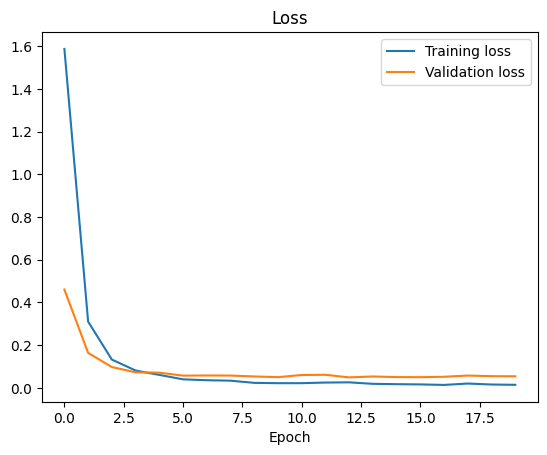

In [20]:
from tqdm import tqdm

train_losses = []
val_losses = []
for epoch in range(epoch_size):
    model.train()
    train_loss = 0
    for input_ids, attention_mask, labels in tqdm(train_loader):
        model.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_losses.append(train_loss / len(train_loader))

    # Validation
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for input_ids, attention_mask, labels in validation_loader:
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            
            loss = outputs.loss
            val_loss += loss.item()
    val_losses.append(val_loss / len(validation_loader))
    print(f"Epoch {epoch+1} | Train Loss: {train_losses[-1]} | Validation Loss: {val_losses[-1]}")

import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title('Loss')
plt.xlabel('Epoch')
plt.show()

### Test

In [21]:
model.eval()
with torch.no_grad():
    true_labels = []
    pred_labels = []
    df_test_rows = []
    for input_ids, attention_mask, labels in test_loader:
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        pred_labels.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

        for b in range(input_ids.shape[0]):
            text = tokenizer.decode([token for i, token in enumerate(input_ids[b]) if attention_mask[b][i] == 1])
            pred_label = label_encoder.classes_[torch.argmax(outputs.logits[b]).item()]
            true_label = label_encoder.classes_[labels[b].item()]
            df_test_rows.append({'text': text, 'true_label': true_label, 'pred_label': pred_label, 'correct': pred_label == true_label})

# Data should not be shared publicly.
pd.DataFrame(df_test_rows).to_csv(dataset_path+f"/{experiment_name}_test_data_pred_results.csv")

### Experimental Results

#### Overall Results

In [22]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

accuracy = accuracy_score(true_labels, pred_labels)
precision, recall, f1, _ = precision_recall_fscore_support(
    true_labels, 
    pred_labels, 
    # average='weighted', 
    average='macro',  # Original paper setting (page 8)
    zero_division=0
)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Test Accuracy: 0.9842
Precision: 0.9566
Recall: 0.9555
F1 Score: 0.9543


#### Class-wise Results

In [23]:
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average=None, zero_division=0)

class_names = label_encoder.inverse_transform(list(set(true_labels)))

performance_df = pd.DataFrame({
    'Class': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
})
performance_df.to_csv(f'experimental_results/precision_recall_fscore_{experiment_name}.csv')
performance_df

,Class,Precision,Recall,F1 Score
0,A1010,1.000000,0.985294,0.992593
1,A1020,1.000000,0.987179,0.993548
2,A1030,0.977273,1.000000,0.988506
3,A2010,0.967213,0.983333,0.975207
4,A2020,1.000000,0.888889,0.941176
5,B1010,0.994934,0.994934,0.994934
6,B1020,0.982759,0.942149,0.962025
7,B2010,0.987993,0.996540,0.992248
8,B2020,0.993651,0.996815,0.995231
9,B2030,1.000000,0.888889,0.941176


In [24]:
# Scarce labels (less than 10)
performance_df['Total Sample Size'] = label_cnt[performance_df['Class']].values
performance_df[performance_df['Total Sample Size'] < 10]  # only when F1 Score can be calculated

,Class,Precision,Recall,F1 Score,Total Sample Size
11,B3020,0.0,0.0,0.0,6
33,D3090,1.0,1.0,1.0,4


In [25]:
print('Elapsed time: ', (time.time() - start_time)/60, ' minutes')

Elapsed time:  51.5744752963384  minutes
